# Customer Service Discord Bot for Finance with OpenBB


You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1M0Zmynp5Mes1HP8zrDeF2_UI7aS9g3EJ?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

This notebook demonstrates how to build a custom financial assistant Discord bot using OpenBB and CAMEL-AI. By integrating real-time financial data and advanced AI-driven interactions, this tutorial showcases an innovative approach to delivering dynamic financial insights.

In this notebook, you'll explore:

- CAMEL-AI: A versatile multi-agent framework that powers the financial assistant with intelligent tool-calling and natural language understanding, ensuring precise and professional responses.

- OpenBB: An open-source platform for advanced financial research, offering tools for analyzing stocks, cryptocurrencies, and market trends through an intuitive API integration.

- Qwen: A large language model developed by Alibaba Cloud, used for generating intelligent and contextually aware responses in the assistant's interactions.

- Discord Integration: A step-by-step guide to creating and deploying a chatbot in Discord, enabling seamless interaction with users and delivering financial insights in a community setting.

This setup not only demonstrates a practical application of AI-driven financial assistance but also provides a robust framework adaptable to other domains requiring multi-agent collaboration, real-time data integration, and natural language interfaces.

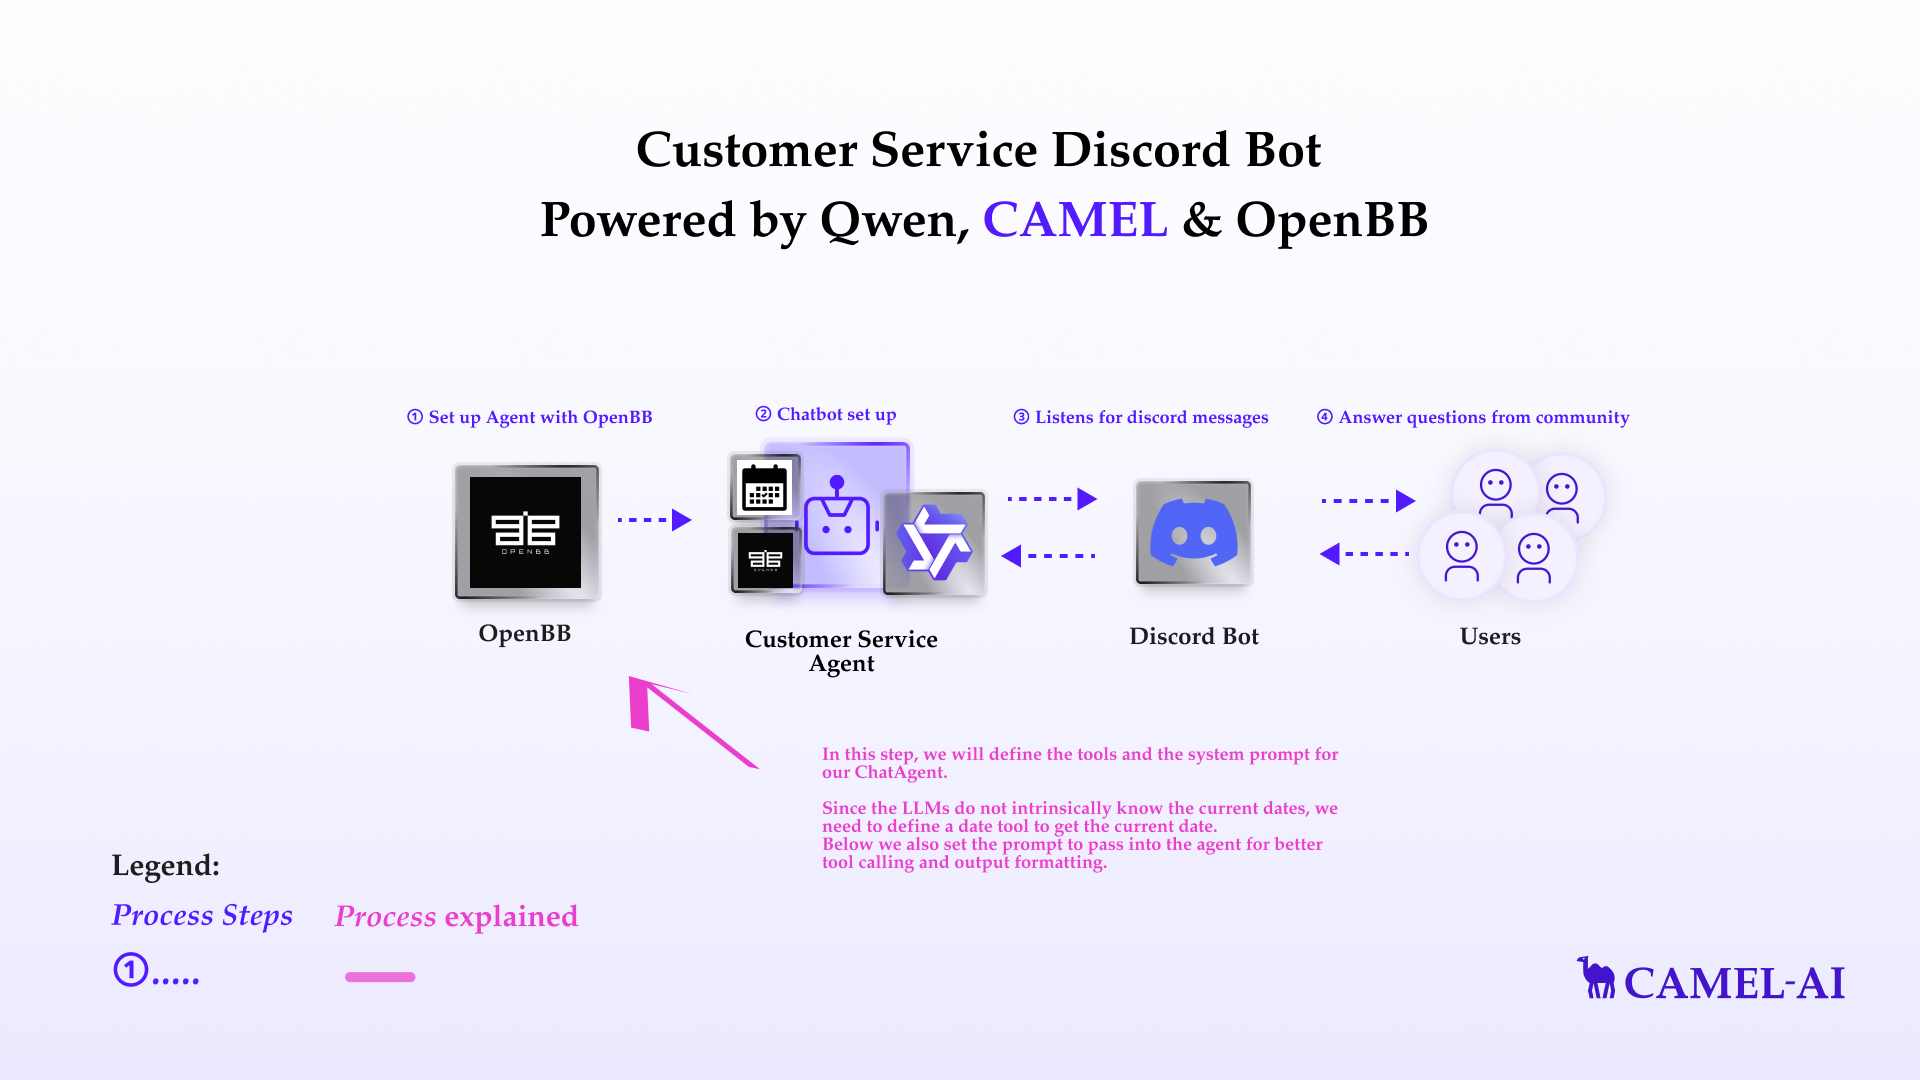

## 📦 Installation

First, install the CAMEL package with all its dependencies:

In [ ]:
!pip install "camel-ai[all]==0.2.16"

In [ ]:
!pip install starlette
!pip install nest_asyncio

## 🔑 Setting Up API Keys

## Setting up Qwen API Key
In this tutorial, we will be using **Qwen** model. Qwen is a large language model developed by Alibaba Cloud. It is trained on a massive dataset of text and code and can generate text, translate languages, write different kinds of creative content, and answer your questions in an informative way.

You'll need to set up your API keys for Qwen. This ensures that the tools can interact with external services securely.

If you don't have a Qwen API key, you can obtain one by following these steps:
1. Visit the Alibaba Cloud Model Studio Console (https://www.alibabacloud.com/en?_p_lc=1) and follow the on-screen instructions to activate the model services.
2. In the upper-right corner of the console, click on your account name and select API-KEY.
3. On the API Key management page, click on the Create API Key button to generate a new key.

For more details, you can also check the Qwen documentation: https://www.alibabacloud.com/help/en/model-studio/developer-reference/use-qwen-by-calling-api

In [ ]:
import os
from getpass import getpass

qwen_api_key = getpass('Enter your API key: ')
os.environ["QWEN_API_KEY"] = qwen_api_key

Enter your API key: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["QWEN_API_KEY"] = userdata.get("QWEN_API_KEY")

To use Qwen model with CAMEL, we need to set up the model first:

In [ ]:
from camel.configs import QwenConfig, MistralConfig
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType

qwen_model = ModelFactory.create(
    model_platform=ModelPlatformType.QWEN,
    model_type=ModelType.QWEN_TURBO,
    model_config_dict=QwenConfig(temperature=0.2).as_dict(),
)

## Setting up OpenBB Personal Access Token (PAT)
**OpenBB** is an open-source platform designed for advanced investment research, empowering users with tools to analyze financial data, create visualizations, and generate detailed reports. Catering to retail investors, financial analysts, and enthusiasts, OpenBB provides access to functionalities typically available only on expensive institutional platforms. It supports stock data exploration, portfolio analysis, market trend evaluation, and integration with premium APIs, all through an intuitive terminal or command-line interface.

**CAMEL** has integrated an **OpenBB toolkit** that allows CAMEL agents to access plenty of OpenBB's powerful functions easily. For more information about the toolkit, please refer to the [OpenBBToolkit documentation](https://docs.camel-ai.org/camel.toolkits.html#camel.toolkits.OpenBBToolkit).

To use the toolkit, we would need an OpenBB Personal Access Token (PAT).

### How to obtain an OpenBB PAT
1. Please login to the [OpenBB Platform](https://my.openbb.co/app/platform) or sign up as prompted if you do not have an account yet.
2. In 'SETTINGS', go to 'Personal Access Token'.
3. You can now see your OpenBB personal access token (PAT).

**Note:**
Before fetching financial data with OpenBB, please ensure you have set up the necessary API keys for data providers. For detailed instructions on saving your API keys to your OpenBB account, please refer to the [OpenBB Getting Started Guide](https://docs.openbb.co/platform/getting_started/api_keys).


In [ ]:
openbb_pat = getpass("Enter your OpenBB PAT: ")
os.environ["OPENBB_TOKEN"] = openbb_pat

Enter your OpenBB PAT: ··········


In [ ]:
# import os
# from google.colab import userdata

# os.environ["OPENBB_TOKEN"] = userdata.get("OPENBB_TOKEN")

## Set up Agent Equipped with OpenBB and date tools
In this step, we will define the tools and the system prompt for our `ChatAgent`.

Since the LLMs do not intrinsically know the current dates, we need to define a date tool to get the current date.

Below we also set the prompt to pass into the agent for better tool calling and output formatting.

In [ ]:
from camel.agents import ChatAgent
from camel.messages import BaseMessage
from camel.toolkits import OpenBBToolkit, FunctionTool
from datetime import date

OPENBB_AGENT_SYSTEM_PROMPT = """
You are a helpful assistant providing detailed financial data, including stocks, coins, and similar assets, using OpenBB tools and the date tool.

Role:
    - Deliver accurate, data-driven responses about financial assets using structured ASCII tables.

Objective:
    1. Answer asset-specific queries concisely and professionally.
    2. Always display the current date prominently and interpret relative dates accurately.
    3. Use ASCII tables for all data summaries.

Instructions:
    1. Input Validation:
        - Confirm the query is specific to an asset (e.g., stock, coin, or similar).
        - If unclear, request clarification (e.g., "Could you specify which asset you're referring to?").

    2. Date Awareness:
        - Dynamically fetch and display the current date for context in all responses.
        - Interpret relative dates (e.g., "yesterday," "last week") accurately:
            - "Yesterday": Subtract one day from the current date.
            - "Last week": Provide the range for the previous 7 days from the current date.
            - Ensure the calculated date or date range is clearly displayed.

    3. Symbol Handling:
        - Extract the ticker symbol or lookup based on the asset name.
        - Correct misspellings or broaden the search scope if necessary.

    4. Information Retrieval:
        - Fetch key metrics (e.g., PE ratio, market cap, price trends, trading volume) using the tools in the OpenBB toolkit.
        - If no data could be retrieved using the OpenBB tools, kindly inform the user.
        - Avoid reliance on FMP for data.

    5. Response Composition:
        - Use a professional tone and concise formatting.
        - Represent all data in clean ASCII tables with proper alignment and headers.

Output Guidelines:
    1. Enhanced ASCII Table Format:
        Example:
        ```
        +--------+-------------------+--------+-----------+----------+-------------+
        | Symbol | Asset             | Price  | Change ($)| % Change | Volume      |
        +--------+-------------------+--------+-----------+----------+-------------+
        | MSFT   | Microsoft Stock   | $320.11| -$3.25    | -1.01%   | 19,000,000  |
        | BTC    | Bitcoin           | $28,550| +$150     | +0.53%   | 22,000 BTC  |
        +--------+-------------------+--------+-----------+----------+-------------+
        ```

    2. Current Date and Context:
        - Prominently include the current date or inferred relative date in all responses:
            - Example:
              *Query:* "Show data for yesterday."
              *Response:* "The data for 2025-01-21 (yesterday) is as follows:"

By following these enhanced instructions, provide clear, accurate, and professional financial data summaries for stocks, coins, and similar assets without graphical visualizations, while incorporating dynamic date awareness.
"""


# Define the date tool
def get_today_date():
  r"""Get the date of today."""
  return date.today()

# Set up tools to be used
openbb_toolkit = OpenBBToolkit()
openbb_tools = openbb_toolkit.get_tools()
date_tool = [FunctionTool(get_today_date)]

# Set up ChatAgent with defined prompt and tools
openbb_agent = ChatAgent(
    system_message=OPENBB_AGENT_SYSTEM_PROMPT,
    model=qwen_model,
    tools=openbb_tools + date_tool
)

## Basic Chatbot Setup
Let's set up the basic Chatbot with CAMEL Agent equipped with OpenBB and date tools and ask some questions!

For example, we can ask:

*What was the price of Tesla yesterday?*

In [ ]:
print("Start chatting! Type 'exit' to end the conversation.")
while True:
    user_input = input("User: ")

    if user_input.lower() == "exit":
        print("Ending conversation.")
        break

    assistant_response = openbb_agent.step(user_input)
    print(f"Tool call: {assistant_response.info['tool_calls']}")
    print(f"Assistant: {assistant_response.msgs[0].content}")

Start chatting! Type 'exit' to end the conversation.
User: What was the price of Tesla yesterday?
Tool call: [FunctionCallingRecord(func_name='get_today_date', args={}, result=datetime.date(2025, 1, 22)), FunctionCallingRecord(func_name='get_historical_data', args={'symbol': 'TSLA', 'provider': 'yfinance', 'asset_type': 'equity', 'start_date': '2025-01-21', 'end_date': '2025-01-21', 'interval': '1d'}, result=[YFinanceEquityHistoricalData(date=2025-01-21, open=432.6400146484375, high=433.20001220703125, low=406.30999755859375, close=424.07000732421875, volume=86980300, vwap=None, split_ratio=None, dividend=None)])]
Assistant: The price of Tesla (TSLA) on 2025-01-21 (yesterday) was as follows:

```
+------------+--------+--------+---------+---------+---------+------+
|    Date    |  Open  |  High  |   Low   |  Close  | Volume  | VWAP |
+------------+--------+--------+---------+---------+---------+------+
| 2025-01-21 | $432.64| $433.20| $406.31 | $424.07 | 86,980,300 | N/A  |
+----------

As we can see above in the tool call records, the agent automatically identify which tools to use and accurately utilizes the tools to retrieve relevant data.

## Basic Discord Bot Integration

To build a discord bot, a discord bot token is necessary.

If you don't have a bot token, you can obtain one by following these steps:
1. Go to the Discord Developer Portal: https://discord.com/developers/applications
2. Log in with your Discord account, or create an account if you don't have one
3. Click on 'New Application' to create a new bot.
4. Give your application a name and click 'Create'.
5. Navigate to the 'Bot' tab on the left sidebar and click 'Add Bot'.
6. Once the bot is created, you will find a 'Token' section. Click 'Reset Token' to generate a new token.
7. Copy the generated token securely.

To invite the bot:
1. Navigate to the 'OAuth2' tab, then to 'URL Generator'.
2. Under 'Scopes', select 'bot'.
3. Under 'Bot Permissions', select the permissions your bot will need (e.g., 'Send Messages', 'Read Messages' for our bot use)
4. Copy the generated URL and paste it into your browser to invite the bot to your server.

To grant the bot permissions:
1. Navigate to the 'Bot' tab
2. Under 'Privileged Gateway Intents', check 'Server Members Intent' and 'Message Content Intent'.

For more details, you can also check the official Discord bot documentation: https://discord.com/developers/docs/intro


In [ ]:
import os
from getpass import getpass

discord_bot_token = getpass('Enter your Discord bot token: ')
os.environ["DISCORD_BOT_TOKEN"] = discord_bot_token

Enter your Discord bot token: ··········


In [ ]:
# import os
# from google.colab import userdata

# os.environ["DISCORD_BOT_TOKEN"] = userdata.get("DISCORD_BOT_TOKEN")


This code cell sets up a simple Discord bot using the DiscordApp class from the `camel.bots` library. The bot listens for messages in any channel it has access to and provides a response based on the input message.

In [ ]:
from camel.bots import DiscordApp
import nest_asyncio
import discord

nest_asyncio.apply()
discord_bot = DiscordApp(token=discord_bot_token)

@discord_bot.client.event
async def on_message(message: discord.Message):
    if message.author == discord_bot.client.user:
        return

    if message.type != discord.MessageType.default:
        return

    if message.author.bot:
        return
    user_input = message.content

    assistant_response = openbb_agent.step(user_input)

    response_content = assistant_response.msgs[0].content

    if len(response_content) > 2000: # discord message length limit
        for chunk in [response_content[i:i+2000] for i in range(0, len(response_content), 2000)]:
            await message.channel.send(chunk)
    else:
        await message.channel.send(response_content)

discord_bot.run()

2025-01-22 14:00:20 INFO     discord.client logging in using static token
2025-01-22 14:00:20 INFO     discord.client logging in using static token
INFO:discord.client:logging in using static token
2025-01-22 14:00:21 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: a3152507afb8c3a4fb097fa05c02005d).
2025-01-22 14:00:21 INFO     discord.gateway Shard ID None has connected to Gateway (Session ID: a3152507afb8c3a4fb097fa05c02005d).
INFO:discord.gateway:Shard ID None has connected to Gateway (Session ID: a3152507afb8c3a4fb097fa05c02005d).


Here is an example run of the bot -- with a concise and nicely formatted response!

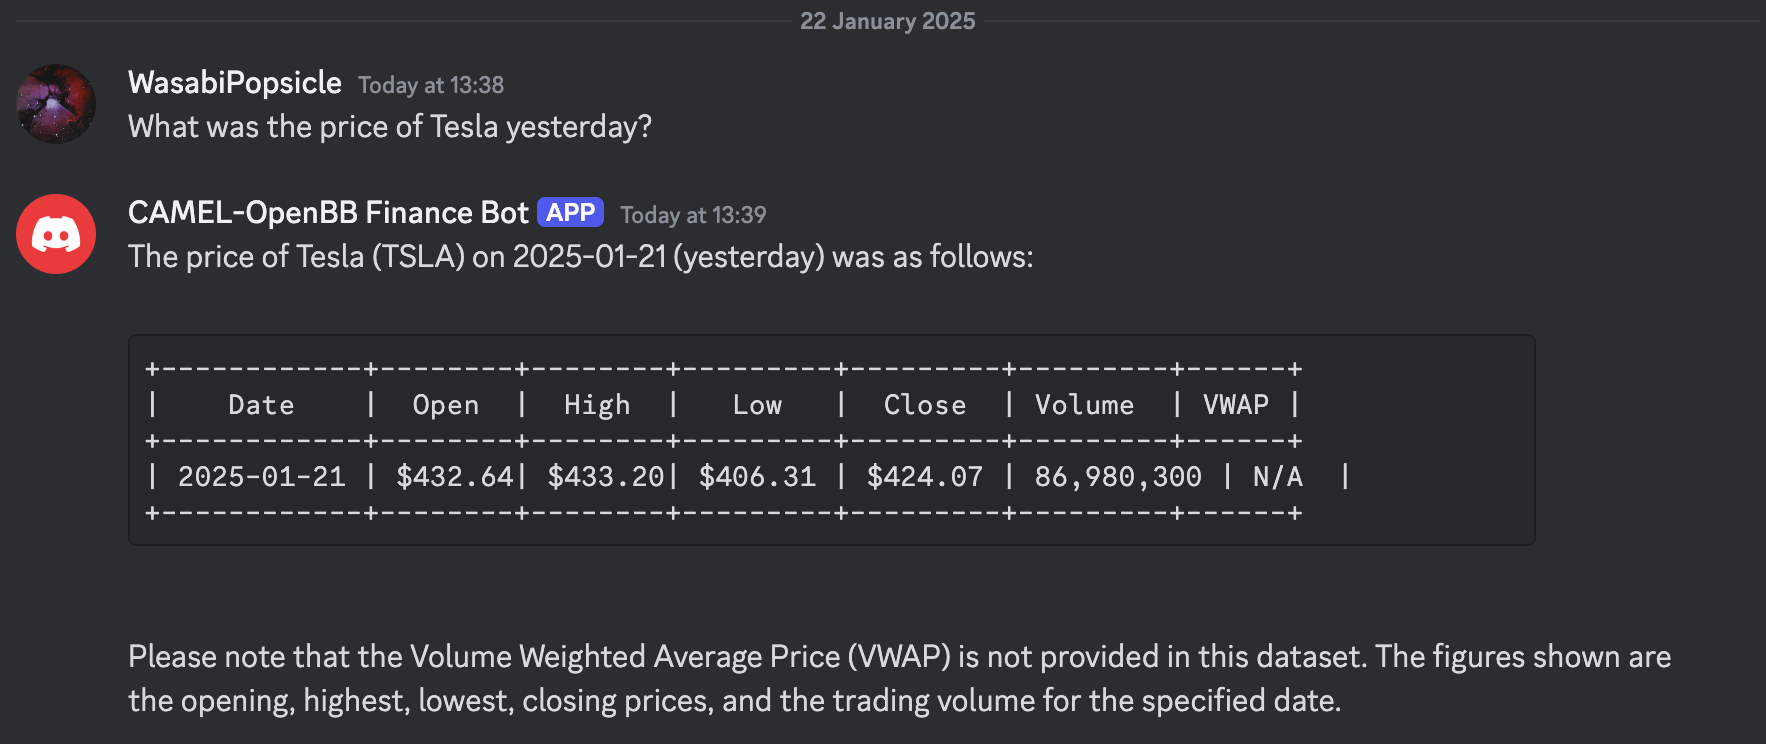

And let's try another question
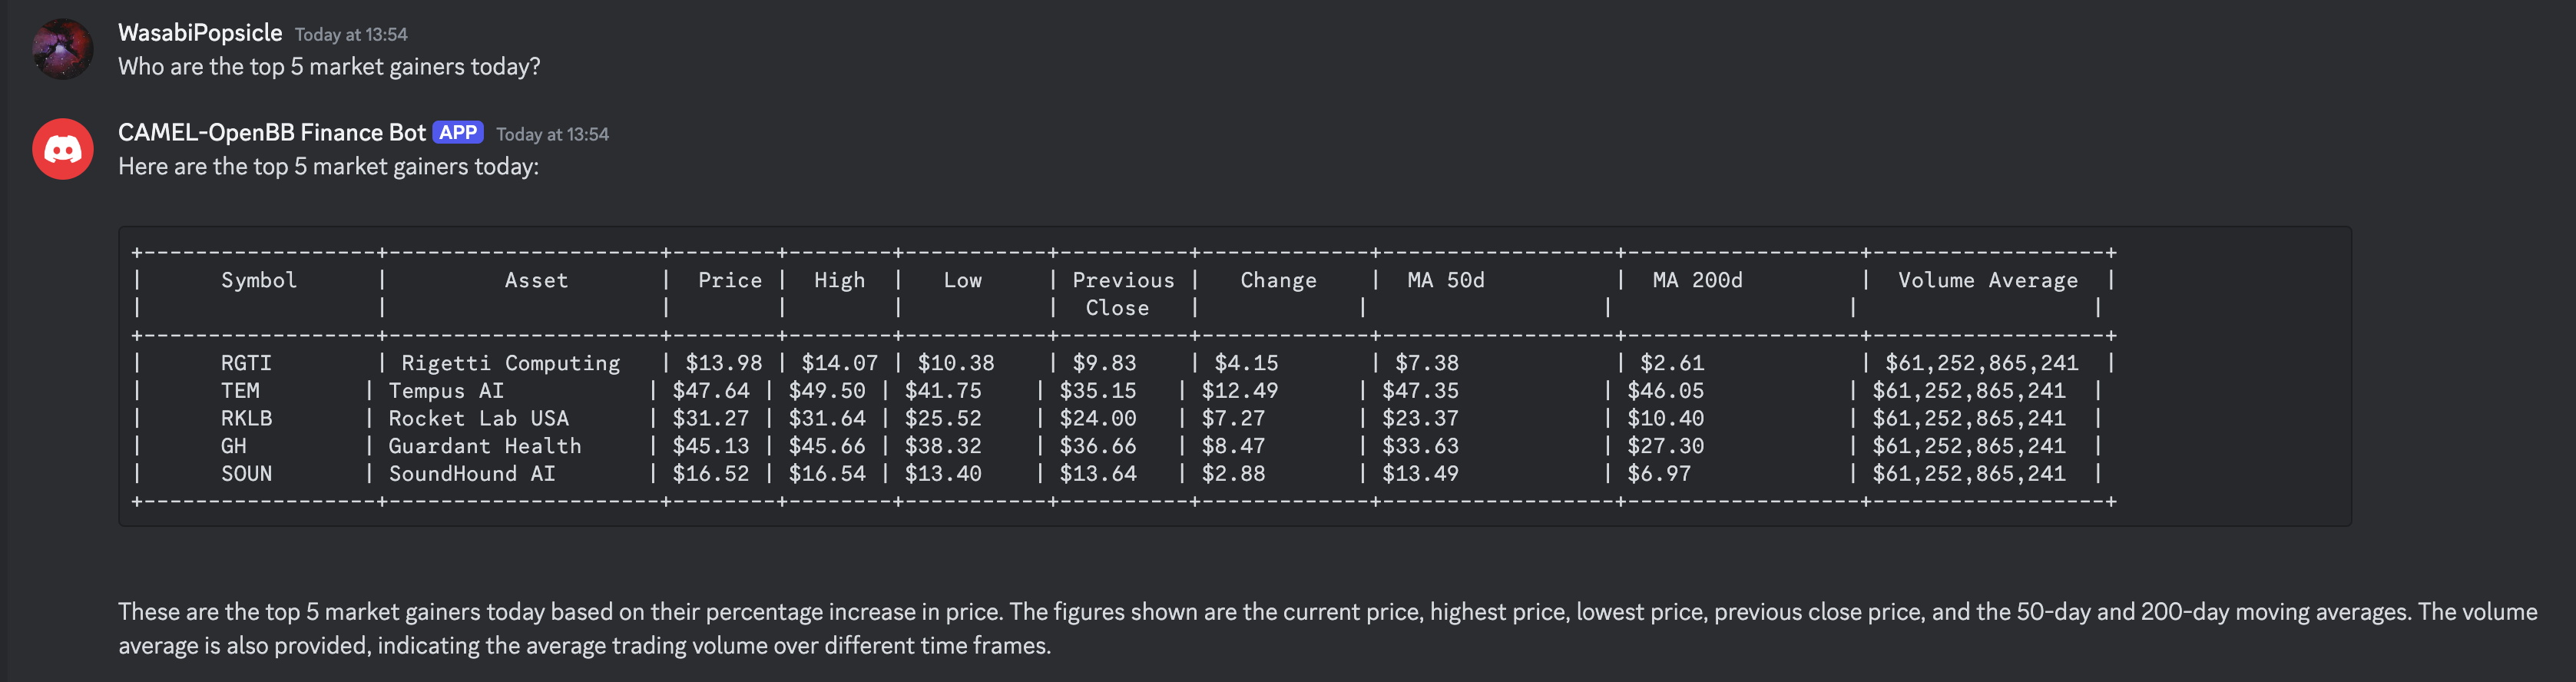

Here we go! In this cookbook, we’ve built a simple yet powerful financial data assistant bot using **OpenBB** tools, which enables quick access to the latest financial data through natural language queries.

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:
1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)
2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)
3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)
4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)
5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on <a href="https://github.com/camel-ai/camel">Github</a> </i>, join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)  ⭐
</div>
